# Research Question 3: Does Google search activity related to Bitcoin predict short-term market momentum or volatility?

In [1]:
# reading csv files
import sys
sys.path.append("../src/")

from helper import data

# plotting graphs & computing results
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller


In [2]:
df_btc = data.load_btc_2018_2019("../data/btc_2018_2019.csv")
df_search = data.load_google_search("../data/btc_search_2018_2019.csv")


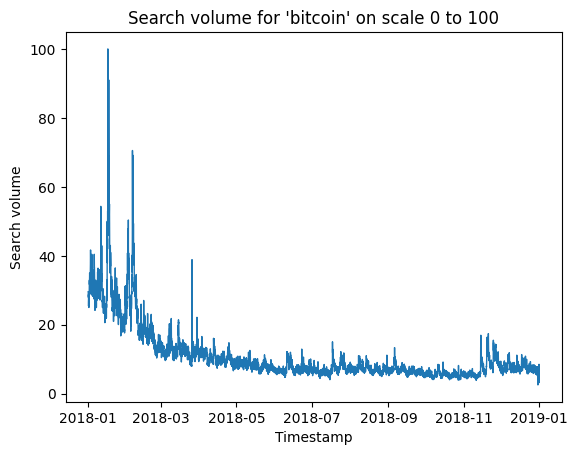

In [3]:
# plotting the bitcoin search volume
plt.plot(df_search["date"], df_search["Scale_['bitcoin']"], lw=1)
plt.xlabel("Timestamp")
plt.ylabel("Search volume")
plt.title("Search volume for 'bitcoin' on scale 0 to 100")
plt.show()


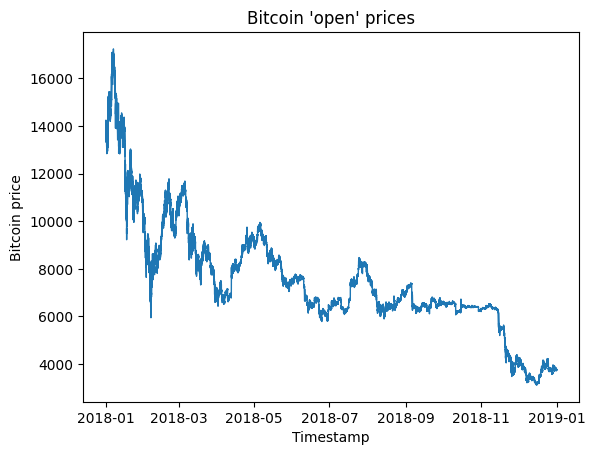

In [4]:
# plotting the bitcoin price data for 'open' column
plt.plot(df_btc["timestamp"], df_btc["open"], lw=1)
plt.xlabel("Timestamp")
plt.ylabel("Bitcoin price")
plt.title("Bitcoin 'open' prices")
plt.show()


### Volatility

We define short term volatility as standard diviation of the bitcoin prices in a 24h window. In this section we look at the volatility against the Google search volume. It's important to note the search volume is normalised to scale between 0 and 100. Which means that any future predictions that may come from the model should be run on a search volume normalised to this set.

In [5]:
# standard diviation for bitcoin prices in the following 24h
df_btc_daily_std = (
    df_btc.group_by_dynamic(
        index_column="timestamp",
        every="1h",
        period="24h",
    )
    .agg(
        pl.col("open").std().alias("daily_stddv")
    )
)


In [6]:
# merging the data frames on the timestamp
df_search = df_search.rename({"date": "timestamp"})
df_search_stddv = df_search.join(
    df_btc_daily_std,
    on="timestamp",
    how="inner"
)


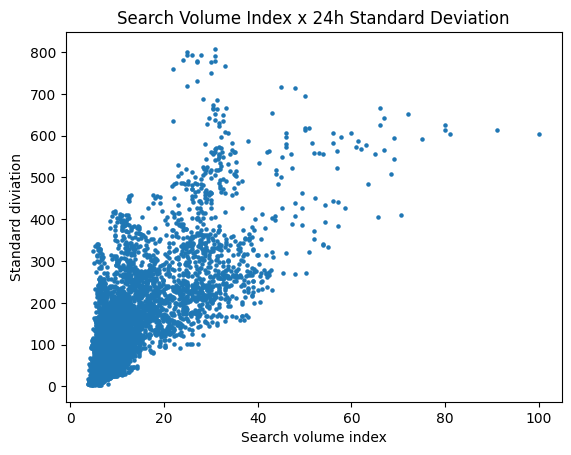

In [7]:
plt.scatter(df_search_stddv["Scale_['bitcoin']"], df_search_stddv["daily_stddv"], s = 5)
plt.xlabel("Search volume index")
plt.ylabel("Standard diviation")
plt.title("Search Volume Index x 24h Standard Deviation")
plt.show()

In [8]:
# correlation
correlation = df_search_stddv.select(
    pl.corr("Scale_['bitcoin']", "daily_stddv")
).item()

print("Correlation:", correlation)


Correlation: 0.7630646929940774


In [9]:
X = np.array(sm.add_constant(df_search_stddv["Scale_['bitcoin']"]))
Y = np.array(df_search_stddv["daily_stddv"])

# Fit model
model = sm.OLS(Y, X).fit()

# Print results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                 1.226e+04
Date:                Mon, 08 Dec 2025   Prob (F-statistic):               0.00
Time:                        15:38:31   Log-Likelihood:                -50178.
No. Observations:                8800   AIC:                         1.004e+05
Df Residuals:                    8798   BIC:                         1.004e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9154      1.284      0.713      0.4

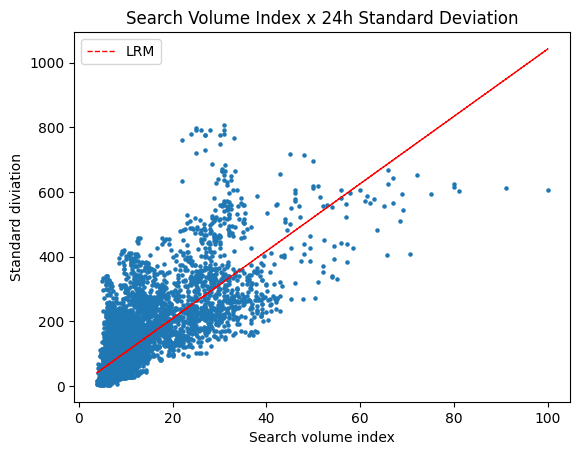

In [10]:
plt.scatter(df_search_stddv["Scale_['bitcoin']"], df_search_stddv["daily_stddv"], s = 5)

x = df_search_stddv["Scale_['bitcoin']"]
y = 0.9154 + 10.4165 * x
plt.plot(x, y, color='red', lw=1, ls="--", label="LRM")

plt.xlabel("Search volume index")
plt.ylabel("Standard diviation")
plt.title("Search Volume Index x 24h Standard Deviation")
plt.legend()
plt.show()

The strong correlation (0.76) and high $R^2$ (0.582) initially suggests that there is a moderate relationship between the google search volume and volatility. However the low Durbin-Watson value (0.057) indicates that the correlation might be due to autocorrelation.

This is why we try to make the series stationary and then test the correlation between the series.

In [11]:
# differences in search volume
df_search_diff = (
    df_search
    .with_columns(pl.col("Scale_['bitcoin']").diff().alias("search_diff"))
    .drop("Scale_['bitcoin']")
)


In [12]:
# merging the data frames on the timestamp
df_search_stddv = df_search_diff.join(
    df_btc_daily_std,
    on="timestamp",
    how="inner"
)

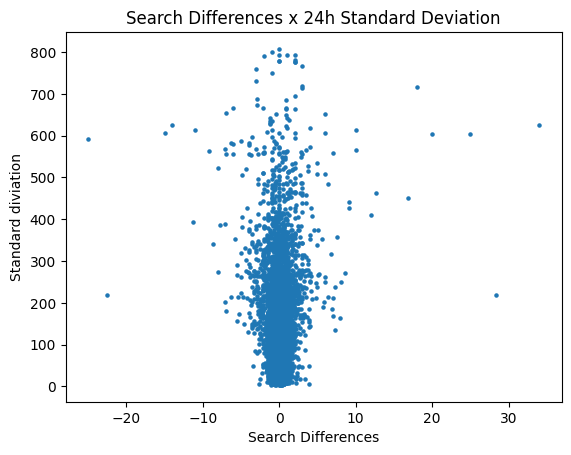

In [13]:
plt.scatter(df_search_stddv["search_diff"], df_search_stddv["daily_stddv"], s = 5)
plt.xlabel("Search Differences")
plt.ylabel("Standard diviation")
plt.title("Search Differences x 24h Standard Deviation")
plt.show()

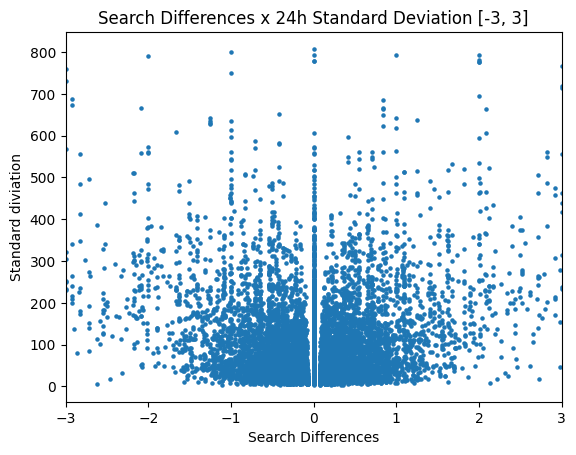

In [14]:
plt.scatter(df_search_stddv["search_diff"], df_search_stddv["daily_stddv"], s = 5)
plt.xlabel("Search Differences")
plt.ylabel("Standard diviation")
plt.title("Search Differences x 24h Standard Deviation [-3, 3]")
plt.xlim(-3, 3)
plt.show()

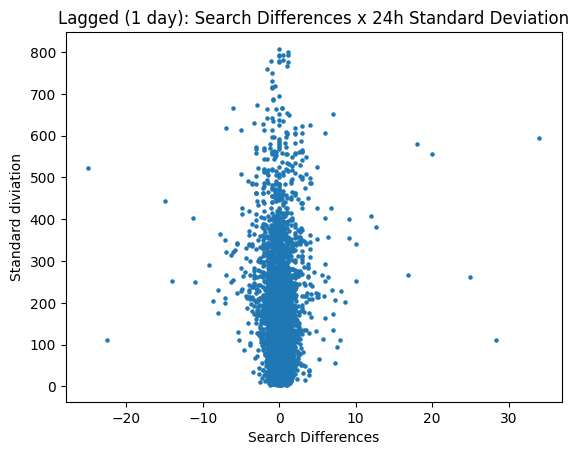

In [15]:
plt.scatter(df_search_stddv["search_diff"][:-24], df_search_stddv["daily_stddv"][24:], s = 5)
plt.xlabel("Search Differences")
plt.ylabel("Standard diviation")
plt.title("Lagged (1 day): Search Differences x 24h Standard Deviation")
plt.show()

In [16]:
# correlation
correlation = df_search_stddv.select(
    pl.corr("search_diff", "daily_stddv")
).item()

print("Correlation:", correlation)

Correlation: 0.02702367193749843


The scatter plot and the resulting correlation coefficient of 0.027 indicate that there is essentially no linear association between changes in Google search volume and short-term Bitcoin volatility.

### Momentum

Momentum is defined as: $M = V_t - V_{t - x}$

In the following section the relationship between momentum and changes in search volume is observed. Momentum is measured for x = {1, 6, 12, 24, 48} (in hours).

In [24]:
hours = [1, 6, 12, 24, 48]

df_btc_hourly = df_btc.filter(
    (pl.col("timestamp").dt.minute() == 0) &
    (pl.col("timestamp").dt.second() == 0)
)

df_momentum = df_btc_hourly.select(
    [
        "timestamp",
        *[
            (pl.col("open") - pl.col("open").shift(h)).alias(f"price_diff_{h}h")
            for h in hours
        ]
    ]
)


In [26]:
# merging the data frames on the timestamp
df_search_momentum = df_search_diff.join(
    df_momentum,
    on="timestamp",
    how="inner"
)


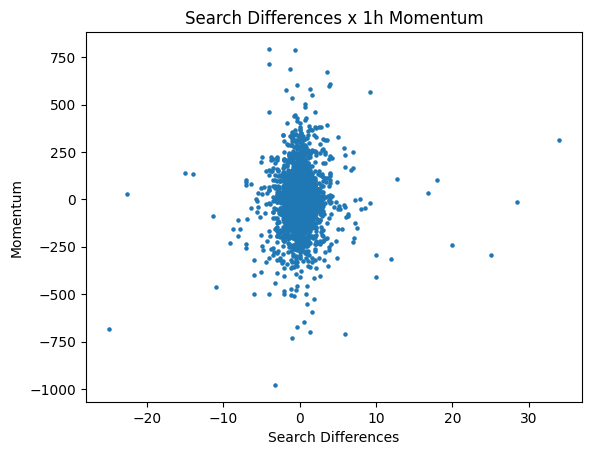

In [28]:
plt.scatter(df_search_momentum["search_diff"], df_search_momentum["price_diff_1h"], s = 5)
plt.xlabel("Search Differences")
plt.ylabel("Momentum")
plt.title("Search Differences x 1h Momentum")
plt.show()

In [32]:
# correlation
for h in hours:
    correlation = df_search_momentum.select(
        pl.corr("search_diff", f"price_diff_{h}h")
        ).item()

    print(f"Correlation for x = {h}h:", correlation)

Correlation for x = 1h: 0.05005496676835554
Correlation for x = 6h: 0.029947219058977254
Correlation for x = 12h: 0.010951210473546847
Correlation for x = 24h: 0.005639570930149383
Correlation for x = 48h: 0.02079005287037493


The correlation scores indicate that there is no meaningfull relationship between momentum (for all tested x) and changes in the search volume. 